Inspired from:

- [Model Convolution: A Computational Approach to Digital Image Interpretation, 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2864900/)

In [1]:
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("../../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
import skimage

../../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


In [2]:
# Define the structure of the MT
# as a 2D array where:
# - x corresponds to rows of dimers.
# - y corresponds to each protofilaments.

n_pf = 13
long_dimer_distance = 8  # nm
mt_length = 2000  # nm
taper_length_nm = 200  # nm
n_rows = int(np.round(mt_length / long_dimer_distance))
print(n_rows)

dimers = np.ones((n_pf, n_rows))
dimers = anamic.structure.generate_uniform_taper(dimers, taper_length_nm=taper_length_nm)

#_ = anamic.viz.viz_dimers(dimers, start_row=-200, grid=True)

# Calculate the x, y and z positions of each dimers.
positions = anamic.structure.get_dimer_positions(dimers)

# Apply a random rotation parallell to the surface (along the z axis)
# This is to avoid having the seam always at the same location.
rotation = np.deg2rad(np.random.randn() * 360)
Rz = anamic.transformations.rotation_matrix(rotation, [0, 0, 1])
positions[['x', 'y', 'z']] = np.dot(positions[['x', 'y', 'z']].values, Rz[:3, :3].T)

# Apply a certain labeling ratio
labeling_ratio = 0.1
positions['labeled'] = np.random.random(positions.shape[0]) < labeling_ratio

anamic.viz.viz_dimer_positions(positions, size=0.4, color_feature_name='pf')

250


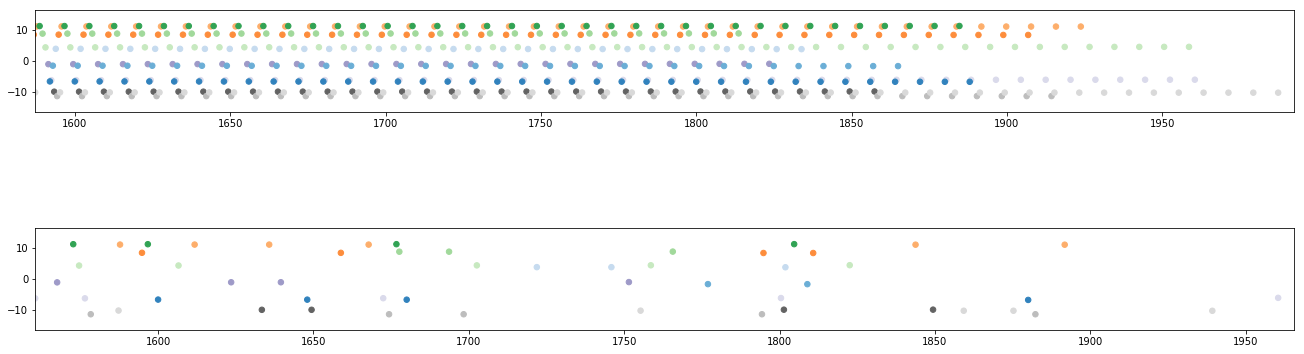

In [3]:
# Project 3D coordinate to 2D plan
positions[['x_proj', 'y_proj']] = positions[['x', 'z']].copy()

visualize = True

if visualize:
    color_feature = 'pf'
    marker_size = 30
    
    fig, axs = plt.subplots(nrows=2, figsize=(18, 6), constrained_layout=True)
    
    # Visualize all dimers
    selected_dimers = positions[(positions['visible'] == True)]
    anamic.viz.viz_2d_dimers_positions(axs[0], selected_dimers,
                                       x_feature="y_proj", y_feature="x_proj",
                                       color_feature=color_feature, marker_size=marker_size,
                                       x_offset=400)

    # Visualize only labeled dimers
    selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]
    anamic.viz.viz_2d_dimers_positions(axs[1], selected_dimers,
                                       x_feature="y_proj", y_feature="x_proj",
                                       color_feature=color_feature, marker_size=marker_size,
                                       x_offset=400)

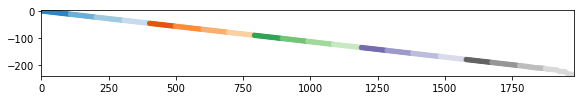

In [4]:
# Apply a random rotation of the projected microtubule positions

random_angle = np.deg2rad(np.random.randn() * 180)
R = anamic.transformations.rotation_matrix(random_angle, [0, 0, 1])

positions['x_proj_rotated'] = np.nan
positions['y_proj_rotated'] = np.nan
positions[['x_proj_rotated', 'y_proj_rotated']] = np.dot(positions[['x_proj', 'y_proj']], R[:2, :2].T)

visualize = True

if visualize:
    color_feature = 'row'
    marker_size = 20
    
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

    selected_dimers = positions[(positions['visible'] == True)]
    selected_dimers = selected_dimers.groupby('row').mean().reset_index()
    anamic.viz.viz_2d_dimers_positions(ax, selected_dimers,
                                       x_feature="y_proj_rotated", y_feature="x_proj_rotated",
                                       color_feature=color_feature, marker_size=marker_size)

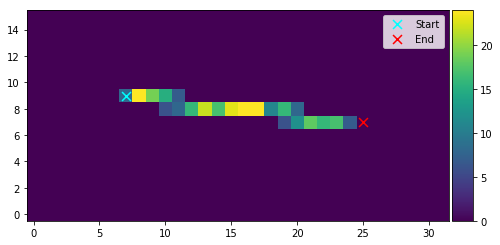

In [5]:
# Discretize dimers onto an high resolution image

pixel_size = 110  # nm/pixel

x_offset = 800  # nm
y_offset = 800  # nm

x_max = int(np.round(positions['x_proj_rotated'].max() + 1))
x_min = int(np.round(positions['x_proj_rotated'].min() - 1))
y_max = int(np.round(positions['y_proj_rotated'].max() + 1))
y_min = int(np.round(positions['y_proj_rotated'].min() - 1))

x_bins = np.arange(x_min - x_offset, x_max + x_offset, pixel_size)
y_bins = np.arange(y_min - y_offset, y_max + y_offset, pixel_size)

# Select visible and labeled dimers
selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]

# Bin dimers positions to a 2D grid (defined by pixel_size)
im, _, _ = np.histogram2d(selected_dimers['x_proj_rotated'], selected_dimers['y_proj_rotated'], bins=[x_bins, y_bins])

# Keep the width > height consistant
if im.shape[1] < im.shape[0]:
    im = im.T
    positions[['x_proj', 'y_proj']] = positions.loc[:, ['y_proj', 'x_proj']]
    positions[['x_proj_rotated', 'y_proj_rotated']] = positions.loc[:, ['y_proj_rotated', 'x_proj_rotated']]
    x_bins, y_bins = y_bins, x_bins

# We also save the dimers positions on the fine grid (unit is pixel)
# The pixel_shift is not ideal but seems to be necessary...
pixel_shift = -1
positions.loc[:, 'x_pixel'] = np.digitize(positions['x_proj_rotated'], x_bins) + pixel_shift
positions.loc[:, 'y_pixel'] = np.digitize(positions['y_proj_rotated'], y_bins) + pixel_shift
    
fig, ax = plt.subplots(figsize=(8, 8))
anamic.viz.imshow_colorbar(im, ax)

anamic.viz.show_tips(ax, positions, coordinates_features=['y_pixel', 'x_pixel'], marker_size=80)

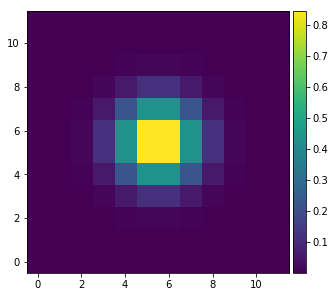

In [6]:
# Generate a microscope PSF

def generate_psf(kernel_size_pixel, sigma_pixel):
    from scipy import signal
    gaussian_kernel_1d = signal.gaussian(kernel_size_pixel, std=sigma_pixel)
    gaussian_kernel_1d = gaussian_kernel_1d.reshape(kernel_size_pixel, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    return gaussian_kernel_2d

psf_size = 135  # nm
sigma_pixel = psf_size / pixel_size

psf = generate_psf(int(sigma_pixel * 10), sigma_pixel)

fig, ax = plt.subplots(figsize=(5, 5))
anamic.viz.imshow_colorbar(psf, ax)

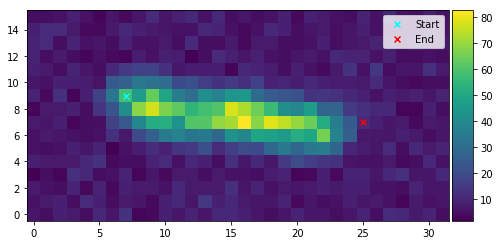

In [10]:
# Convolve image with PSF
from scipy import ndimage
image = ndimage.convolve(im, psf, mode="constant")

# Add offset signal
image = image + image.max() * 0.1

# Add noise
noise_factor = 10
noise = np.random.poisson(image).astype(float) * noise_factor
image = image + noise
image /= 10

x_start, x_end, y_start, y_end = anamic.structure.get_mt_tips(positions, coordinates_features=['y_pixel', 'x_pixel'])

fig, ax = plt.subplots(figsize=(8, 8))
anamic.viz.imshow_colorbar(image, ax)
ax.scatter([x_start], [y_start], color='cyan', label='Start', marker='x')
ax.scatter([x_end], [y_end], color='red', label='End', marker='x')
ax.legend()

In [136]:
# TODO: Estimate the SNR
signal_indices = np.where(im5 > 6000)
background_indices = np.where(im5 < 6000)
signal = im5[signal_indices]
bg = im5[background_indices]
snr = (signal.mean() - bg.mean()) / np.sqrt(signal.std()**2 + bg.std()**2)